In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(conn)
inspector = inspect(conn)
#using inspector to print the column names within the "measurement" table
m_columns = inspector.get_columns('measurement')
for column in m_columns:
    print(column["name"])
print("--------------------")
#using inspector to print the column names within the "station" table
s_columns = inspector.get_columns('station')
for s in s_columns:
    print(s["name"])

id
station
date
prcp
tobs
--------------------
id
station
name
latitude
longitude
elevation


# Exploratory Precipitation Analysis

In [16]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year_date = (dt.datetime.strptime(last_date[0], '%Y-%m-%d'))\
                    - (dt.timedelta(days = 365))
last_year_date

datetime.datetime(2016, 8, 23, 0, 0)

In [25]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date

'2017-08-23'

Checking for null values
There are 209 null values - dropping!!!
Plotting the Precipitation data


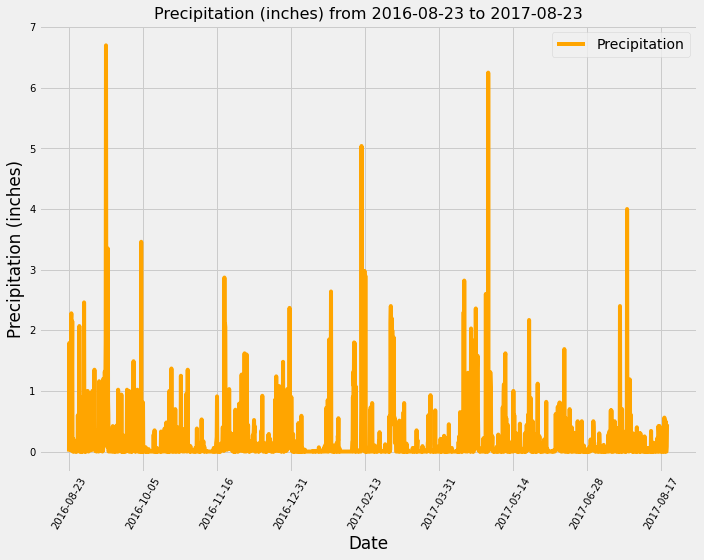

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# convert string sate to sate format so we can use it with datetime library.
convert_lastdate = (dt.datetime.strptime(last_date, "%Y-%m-%d")).date()

# Calculate the date one year from the last date in data set.
prev_year = convert_lastdate - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation 
prcp_data = session.query(Measurement.date, Measurement.prcp).\
            filter((Measurement.date >= prev_year)\
            & (Measurement.date <= convert_lastdate)).all()
      
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcpdata_df = pd.DataFrame(prcp_data, columns = ["Date", "Precipitation"]).sort_values("Date").set_index("Date")

# check and drop the null values
print("Checking for null values")
print(f"There are {prcpdata_df['Precipitation'].isnull().sum()} null values - dropping!!!")
prcpdata_df.dropna(axis=0, how="any", inplace=True)

print("Plotting the Precipitation data")

# Use Pandas Plotting with Matplotlib to plot the data
prcpdata_df.plot(color="Orange", figsize=(10,8), fontsize=10, rot=60)
plt.title(f"Precipitation (inches) from {prev_year} to {last_date}", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.tight_layout()
plt.savefig("Resources/prcp.png")
plt.show()


In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpdata_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.station).count()
print(f"There are {station_count} stations in Station datasets.\n")
from sqlalchemy import distinct
m_station_count = session.query(distinct(Measurement.station)).count()
print(f"There are {m_station_count} stations in Measurement datasets.\n")

There are 9 stations in Station datasets.

There are 9 stations in Measurement datasets.



In [29]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        filter(Station.station == Measurement.station).group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
print(f"Most active stations are:")
active_stations

Most active stations are:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Identify most active station
most_active_station = active_stations[0][0]
most_active_station
print(f"The most active station is {most_active_station}.")                                      
print("__________________________________")                                      

#calculate the lowest temp at the most active station
lowest_temp = session.query(func.min(Measurement.tobs)).\
              filter(Measurement.station == most_active_station).scalar()
print(f"Lowest temperature: {lowest_temp}F")

#calculate the highest temp at the most active station
highest_temp = session.query(func.max(Measurement.tobs)).\
              filter(Measurement.station == most_active_station).scalar()
print(f"Highest temperature: {highest_temp}F") 

#calculate the avg temp at the most active station
avg_temp = session.query(func.avg(Measurement.tobs)).\
              filter(Measurement.station == most_active_station).scalar()
print(f"Average temperature: {avg_temp}F") 


The most active station is USC00519281.
__________________________________
Lowest temperature: 54.0F
Highest temperature: 85.0F
Average temperature: 71.66378066378067F


Text(0.5, 1.0, 'Avg temperature for last year at station - USC00519281')

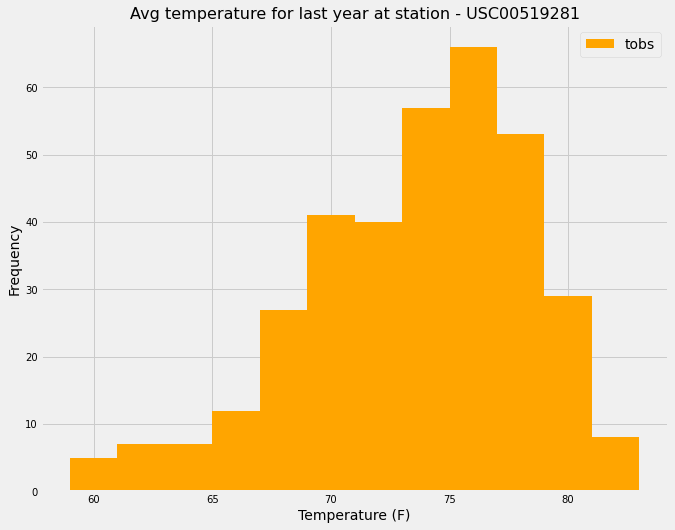

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_temp = session.query(Measurement.date, Measurement.tobs).\
                filter((Measurement.date >= prev_year) & \
                (Measurement.station == active_stations[0][0])).all()
# Convery the query object to DataFram
most_active_temp_df = pd.DataFrame(most_active_temp)
# Plot the histogram of the results
most_active_temp_df.plot(kind="hist", color = "Orange", figsize=(10,8), bins=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Temperature (F)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(['tobs'])
plt.title(f"Avg temperature for last year at station - {most_active_station}", fontsize=16)

# Close session

In [32]:
# Close Session
session.close()